In [11]:
options(warn = -1)

suppressWarnings({
    libs <- c("tidyverse","glmnet","caret")
load.libs <- function(x){
  for(i in x){
    if(!require(i,character.only = TRUE )){
      install.packages(i,dependencies = TRUE )
      library(i,character.only = TRUE )
    }
  }
}
load.libs(libs)
})

In [2]:
dataUnstructured<-read.table("cardio_train.csv",head=T,sep=";")

data<-dataUnstructured[,-1]%>%
    rename(Outcome=cardio)%>%
    mutate(age=round(age/362.25),
           BMI=weight/((height/100)**2))%>%
    select(-c(height,weight))%>%
    select(Outcome,everything())

categorical<-c("gender","cholesterol","gluc","smoke","alco","active","Outcome")
data[,names(data) %in% categorical]<-lapply(data[,names(data)%in%categorical],as.factor)

X<-scale(model.matrix(Outcome~.,data)[,-1],center=T,scale=F)
colnames(X) <- paste0("d_", colnames(X))
data<-cbind(data,X)

In [3]:
paste(paste(colnames(X),collapse="+"),
      paste(names(data[2:11]),collapse="+"),
      sep="+")

[1] "d_age+d_gender2+d_ap_hi+d_ap_lo+d_cholesterol2+d_cholesterol3+d_gluc2+d_gluc3+d_smoke1+d_alco1+d_active1+d_BMI+age+gender+ap_hi+ap_lo+cholesterol+gluc+smoke+alco+active+BMI"

In [4]:
trainingIndices<-data[,"Outcome"]%>%
    createDataPartition(p=0.80,list=F)
trainSet<-data[trainingIndices,]
testSet<-data[-trainingIndices,]
Y_train<-as.matrix(trainSet[,"Outcome"])
Y_test<-as.matrix(testSet[,"Outcome"])

trainDesignMatrix<-model.matrix(Outcome~
                                age+gender+ap_hi+ap_lo+cholesterol+gluc+smoke+alco+active+BMI+
                                (d_age+d_gender2+d_ap_hi+d_ap_lo+d_cholesterol2+d_cholesterol3+d_gluc2+d_gluc3+d_smoke1+d_alco1+d_active1+d_BMI)^2,
                                data=trainSet)
testDesignMatrix<-model.matrix(Outcome~
                               age+gender+ap_hi+ap_lo+cholesterol+gluc+smoke+alco+active+BMI+
                               (d_age+d_gender2+d_ap_hi+d_ap_lo+d_cholesterol2+d_cholesterol3+d_gluc2+d_gluc3+d_smoke1+d_alco1+d_active1+d_BMI)^2,
                               data=testSet)

In [5]:
X_train<-trainDesignMatrix[,!colnames(trainDesignMatrix) %in% colnames(X)][,-1]
X_test<-testDesignMatrix[,!colnames(testDesignMatrix) %in% colnames(X)][,-1]

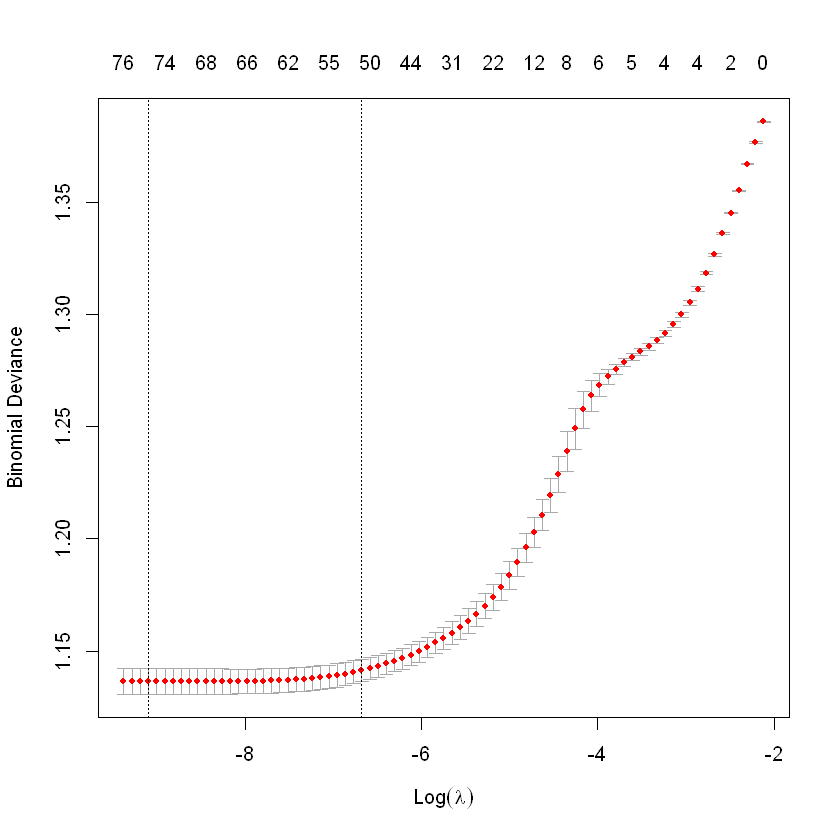

In [6]:
set.seed(50)
CV<-cv.glmnet(X_train,Y_train,
              alpha=1,nfolds=5,family="binomial")
plot(CV)

In [9]:
lasso<-glmnet(X_train,Y_train,
              alpha=1,family="binomial",
              lambda=CV$lambda.min)
coef(lasso)

79 x 1 sparse Matrix of class "dgCMatrix"
                                         s0
(Intercept)                   -8.887313e+00
age                            4.757375e-02
gender2                        7.896558e-02
ap_hi                          4.312189e-02
ap_lo                          4.749386e-04
cholesterol2                   2.784974e-01
cholesterol3                   1.073303e+00
gluc2                          9.677348e-02
gluc3                         -1.822604e-01
smoke1                        -1.147575e-01
alco1                         -1.632014e-01
active1                       -1.981128e-01
BMI                            3.188345e-02
d_age:d_gender2               -1.138209e-02
d_age:d_ap_hi                 -1.531872e-03
d_age:d_ap_lo                 -3.639808e-05
d_age:d_cholesterol2          -2.405251e-02
d_age:d_cholesterol3          -1.780403e-02
d_age:d_gluc2                 -1.607913e-02
d_age:d_gluc3                 -1.092775e-03
d_age:d_smoke1                -7.8

In [21]:
probs<-predict(lasso,X_test)
predictions<-ifelse(probs > 0.5,1,0)
trueValues<-Y_test

metric<-mean(predictions==trueValues)
print(paste0("Model Accuracy: ",round(metric,2)*100,"%"))

[1] "Model Accuracy: 70%"
